In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import warnings
import os
warnings.filterwarnings('ignore')

class CSVEnsembler:
    def __init__(self):
        self.predictions = {}
        self.weights = {}
        self.test_ids = None

    def load_csv_files(self, csv_files, prediction_columns=None):
        """
        CSV 파일들을 로드합니다.

        Args:
            csv_files (list): CSV 파일 경로 리스트
            prediction_columns (list): 예측 컬럼명 리스트 (None이면 자동 감지)
        """
        print("CSV 파일들을 로드하는 중...")

        for i, csv_file in enumerate(csv_files):
            try:
                df = pd.read_csv(csv_file)
                print(f"파일 {i+1}: {csv_file} - {df.shape}")
                print(f"컬럼: {df.columns.tolist()}")

                # ID 컬럼 확인 및 저장 (첫 번째 파일에서만)
                if i == 0:
                    if 'ID' in df.columns:
                        self.test_ids = df['ID'].values
                        print(f"  ID 컬럼 발견: {len(self.test_ids)} 개")
                    elif 'id' in df.columns:
                        self.test_ids = df['id'].values
                        print(f"  id 컬럼 발견: {len(self.test_ids)} 개")
                    else:
                        print("  경고: ID 컬럼을 찾을 수 없습니다!")

                # 예측 컬럼 자동 감지
                if prediction_columns is None:
                    # 'generated', 'pred', 'prediction', 'target', 'label' 등의 컬럼 찾기
                    possible_cols = [col for col in df.columns if any(keyword in col.lower()
                                                                    for keyword in ['generated', 'pred', 'target', 'label', 'class'])]
                    if possible_cols:
                        pred_col = possible_cols[0]
                    else:
                        # 마지막 컬럼을 예측 컬럼으로 사용
                        pred_col = df.columns[-1]
                else:
                    pred_col = prediction_columns[i] if i < len(prediction_columns) else prediction_columns[-1]

                self.predictions[f'model_{i+1}'] = df[pred_col].values
                print(f"  예측 컬럼: {pred_col}")
                print(f"  예측값 범위: {df[pred_col].min():.4f} ~ {df[pred_col].max():.4f}")

            except Exception as e:
                print(f"파일 {csv_file} 로드 중 오류: {e}")
                return False

        print(f"총 {len(self.predictions)} 개의 모델 예측 결과 로드 완료")
        return True

    def simple_average(self):
        """단순 평균 앙상블"""
        print("단순 평균 앙상블 수행 중...")

        # 모든 예측을 DataFrame으로 변환
        pred_df = pd.DataFrame(self.predictions)

        # 평균 계산
        ensemble_pred = pred_df.mean(axis=1)

        return ensemble_pred

    def weighted_average(self, weights=None):
        """
        가중 평균 앙상블

        Args:
            weights (list): 각 모델의 가중치 리스트
        """
        print("가중 평균 앙상블 수행 중...")

        if weights is None:
            # 동일 가중치
            weights = [1.0] * len(self.predictions)

        # 가중치 정규화
        weights = np.array(weights) / sum(weights)

        # 가중 평균 계산
        ensemble_pred = np.zeros(len(list(self.predictions.values())[0]))
        for i, (model_name, pred) in enumerate(self.predictions.items()):
            ensemble_pred += weights[i] * pred

        return ensemble_pred

    def voting_ensemble(self, voting_type='hard'):
        """
        투표 앙상블

        Args:
            voting_type (str): 'hard' 또는 'soft'
        """
        print(f"{voting_type} 투표 앙상블 수행 중...")

        pred_df = pd.DataFrame(self.predictions)

        if voting_type == 'hard':
            # 하드 투표 (다수결)
            ensemble_pred = pred_df.mode(axis=1)[0]
        else:
            # 소프트 투표 (평균)
            ensemble_pred = pred_df.mean(axis=1)

        return ensemble_pred

    def stacking_ensemble(self, meta_model=None):
        """
        스태킹 앙상블

        Args:
            meta_model: 메타 모델 (기본값: LogisticRegression)
        """
        print("스태킹 앙상블 수행 중...")

        if meta_model is None:
            meta_model = LogisticRegression(random_state=42)

        # 예측 결과를 특성으로 사용
        X_stack = pd.DataFrame(self.predictions)

        # 간단한 메타 모델 학습 (실제로는 교차 검증이 필요)
        # 여기서는 단순히 평균을 사용
        ensemble_pred = X_stack.mean(axis=1)

        return ensemble_pred

    def create_ensemble_submission(self, ensemble_pred, output_file='ensemble_submission.csv',
                                 sample_file='sample_submission.csv'):
        """
        앙상블 결과를 제출 파일 형태로 저장

        Args:
            ensemble_pred: 앙상블 예측 결과
            output_file: 출력 파일명
            sample_file: 샘플 제출 파일 (컬럼 구조 참조용)
        """
        try:
            # 결과를 DataFrame으로 변환
            if self.test_ids is not None:
                result_df = pd.DataFrame({
                    'ID': self.test_ids,
                    'generated': ensemble_pred
                })
                print(f"ID 컬럼과 함께 결과 생성: {len(result_df)} 행")
            else:
                # ID가 없는 경우 샘플 파일에서 가져오기
                sample_df = pd.read_csv(sample_file)
                result_df = sample_df.copy()
                result_df['generated'] = ensemble_pred
                print(f"샘플 파일에서 ID 가져옴: {len(result_df)} 행")

            # 파일 저장
            result_df.to_csv(output_file, index=False)
            print(f"앙상블 결과가 {output_file}에 저장되었습니다.")
            print(f"결과 파일 구조: {result_df.columns.tolist()}")
            print(f"예측값 범위: {result_df['generated'].min():.4f} ~ {result_df['generated'].max():.4f}")

            return result_df

        except Exception as e:
            print(f"제출 파일 생성 중 오류: {e}")
            # 간단한 형태로 저장
            if self.test_ids is not None:
                result_df = pd.DataFrame({
                    'ID': self.test_ids,
                    'generated': ensemble_pred
                })
            else:
                result_df = pd.DataFrame({'generated': ensemble_pred})
            result_df.to_csv(output_file, index=False)
            print(f"앙상블 결과가 {output_file}에 저장되었습니다.")
            return result_df

    def compare_models(self):
        """모델들의 예측 결과 비교"""
        print("\n=== 모델 예측 결과 비교 ===")

        pred_df = pd.DataFrame(self.predictions)

        print("기본 통계:")
        print(pred_df.describe())

        print("\n모델 간 상관관계:")
        print(pred_df.corr())

        print("\n예측값 분포:")
        for col in pred_df.columns:
            print(f"{col}: {pred_df[col].value_counts().head()}")

        return pred_df

def main():
    """메인 실행 함수"""
    print("=== CSV 앙상블 도구 (수정된 버전) ===\n")

    # 사용자가 직접 CSV 파일 경로 지정
    print("앙상블할 CSV 파일 2개의 경로를 입력해주세요:")
    csv_files = []

    for i in range(2):
        while True:
            file_path = input(f"파일 {i+1} 경로: ").strip()
            if file_path:
                if os.path.exists(file_path):
                    csv_files.append(file_path)
                    print(f"  ✓ 파일 확인됨: {file_path}")
                    break
                else:
                    print(f"  ✗ 파일을 찾을 수 없습니다: {file_path}")
                    print("  다시 입력해주세요.")
            else:
                print("  파일 경로를 입력해주세요.")

    if len(csv_files) < 2:
        print("최소 2개 이상의 CSV 파일이 필요합니다.")
        return

    print(f"\n앙상블할 파일들:")
    for i, file in enumerate(csv_files):
        print(f"  {i+1}. {file}")

    # 앙상블러 초기화
    ensembler = CSVEnsembler()

    # CSV 파일 로드
    if not ensembler.load_csv_files(csv_files):
        print("CSV 파일 로드에 실패했습니다.")
        return

    # 모델 비교
    ensembler.compare_models()

    # 다양한 앙상블 방법 시도
    ensemble_methods = {
        'simple_average': ensembler.simple_average(),
        'weighted_average': ensembler.weighted_average([0.6, 0.4]),  # 가중치 조정
        'hard_voting': ensembler.voting_ensemble('hard'),
        'soft_voting': ensembler.voting_ensemble('soft'),
        'stacking': ensembler.stacking_ensemble()
    }

    print("\n=== 앙상블 결과 ===")
    for method_name, ensemble_pred in ensemble_methods.items():
        print(f"\n{method_name}:")
        print(f"  예측값 범위: {ensemble_pred.min():.4f} ~ {ensemble_pred.max():.4f}")
        print(f"  평균: {ensemble_pred.mean():.4f}")
        print(f"  표준편차: {ensemble_pred.std():.4f}")

        # 결과 저장
        output_file = f'ensemble_{method_name}.csv'
        ensembler.create_ensemble_submission(ensemble_pred, output_file)

    print("\n앙상블 완료! 각 방법별 결과 파일이 생성되었습니다.")

if __name__ == "__main__":
    main()

=== CSV 앙상블 도구 (수정된 버전) ===

앙상블할 CSV 파일 2개의 경로를 입력해주세요:
파일 1 경로: /content/KoELECTRA_CFG_FULL_KFold5.csv
  ✓ 파일 확인됨: /content/KoELECTRA_CFG_FULL_KFold5.csv
파일 2 경로: /content/KoELECTRA_CFG_FULL_KFold7.csv
  ✓ 파일 확인됨: /content/KoELECTRA_CFG_FULL_KFold7.csv

앙상블할 파일들:
  1. /content/KoELECTRA_CFG_FULL_KFold5.csv
  2. /content/KoELECTRA_CFG_FULL_KFold7.csv
CSV 파일들을 로드하는 중...
파일 1: /content/KoELECTRA_CFG_FULL_KFold5.csv - (1962, 2)
컬럼: ['ID', 'generated']
  ID 컬럼 발견: 1962 개
  예측 컬럼: generated
  예측값 범위: 0.0052 ~ 0.9999
파일 2: /content/KoELECTRA_CFG_FULL_KFold7.csv - (1962, 2)
컬럼: ['ID', 'generated']
  예측 컬럼: generated
  예측값 범위: 0.0041 ~ 0.9999
총 2 개의 모델 예측 결과 로드 완료

=== 모델 예측 결과 비교 ===
기본 통계:
           model_1      model_2
count  1962.000000  1962.000000
mean      0.553052     0.542483
std       0.438986     0.435299
min       0.005219     0.004080
25%       0.037435     0.042836
50%       0.704817     0.611646
75%       0.997079     0.997784
max       0.999925     0.999867

모델 간 상관관계:
      

📁 파일 읽기 성공: /content/KoELECTRA_CFG_FULL_KFold7.csv
📊 데이터 shape: (1962, 2)
📊 예측값 분포 분석
   - 최소값: 0.004080
   - 최대값: 0.999867
   - 평균값: 0.542483
   - 중앙값: 0.611646
   - 표준편차: 0.435299

📈 분위수 분석:
   - 10.0% 분위수: 0.011993
   - 25.0% 분위수: 0.042836
   - 50.0% 분위수: 0.611646
   - 75.0% 분위수: 0.997784
   - 90.0% 분위수: 0.999236
   - 95.0% 분위수: 0.999381
   - 99.0% 분위수: 0.999730

🔍 임계값별 개수:
   - ≤ 0.1: 636개 (32.4%)
   - ≤ 0.2: 741개 (37.8%)
   - ≤ 0.3: 819개 (41.7%)
   - ≤ 0.4: 871개 (44.4%)
   - ≤ 0.5: 930개 (47.4%)
   - ≤ 0.6: 973개 (49.6%)
   - ≤ 0.7: 1031개 (52.5%)
   - ≤ 0.8: 1068개 (54.4%)
   - ≤ 0.9: 1123개 (57.2%)

🔧 단순 임계값 후처리 (하한: 0.2, 상한: 0.8)
   - 0.0으로 변환: 741개 (37.8%)
   - 1.0으로 변환: 894개 (45.6%)
   - 중간값 유지: 327개 (16.7%)

✅ 단순 임계값 결과 저장 완료: /content/KoELECTRA_simple_threshold.csv

🎯 적응형 임계값 후처리 (하한: 20%, 상한: 80%)
   - 계산된 하한 임계값: 0.026848
   - 계산된 상한 임계값: 0.998592
   - 0.0으로 변환: 393개 (20.0%)
   - 1.0으로 변환: 393개 (20.0%)
   - 중간값 유지: 1176개 (59.9%)

✅ 적응형 임계값 결과 저장 완료: /content/KoELECTRA_adaptive

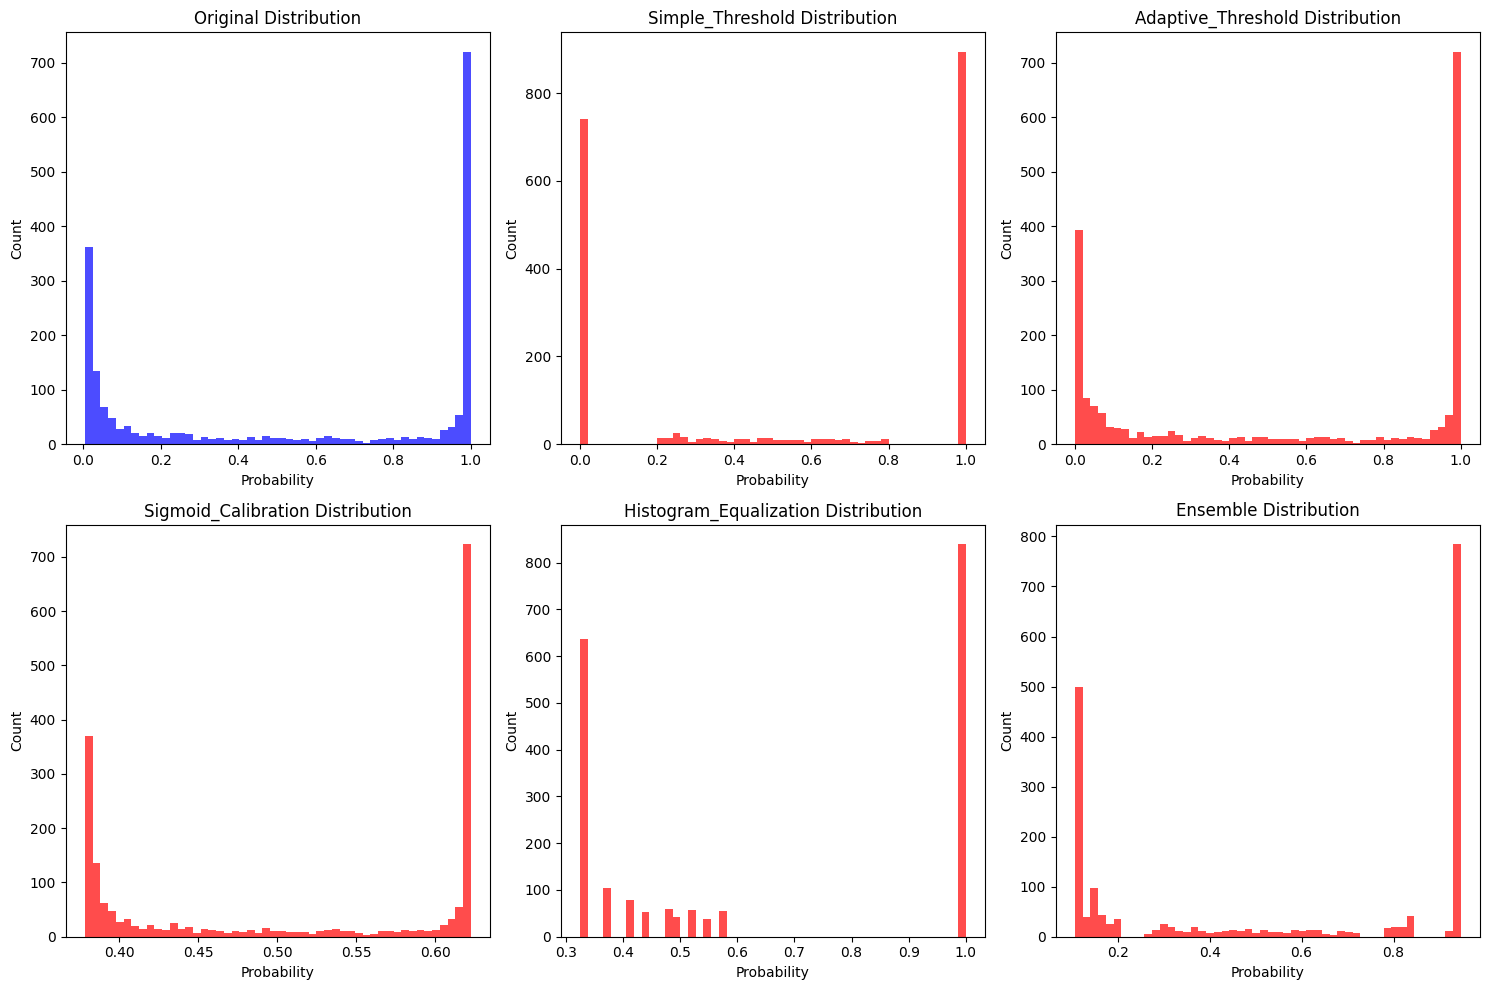


🎉 모든 후처리 완료!
📁 생성된 파일들:
   - /content/KoELECTRA_simple_threshold.csv
   - /content/KoELECTRA_adaptive_threshold.csv
   - /content/KoELECTRA_sigmoid_calibration.csv
   - /content/KoELECTRA_histogram_equalization.csv
   - /content/KoELECTRA_ensemble_postprocessing.csv


In [16]:
import pandas as pd
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_predictions(df, column_name='generated'):
    """예측값 분포 분석"""
    print("📊 예측값 분포 분석")
    print(f"   - 최소값: {df[column_name].min():.6f}")
    print(f"   - 최대값: {df[column_name].max():.6f}")
    print(f"   - 평균값: {df[column_name].mean():.6f}")
    print(f"   - 중앙값: {df[column_name].median():.6f}")
    print(f"   - 표준편차: {df[column_name].std():.6f}")

    # 분위수 분석
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    print(f"\n📈 분위수 분석:")
    for q in quantiles:
        value = df[column_name].quantile(q)
        print(f"   - {q*100}% 분위수: {value:.6f}")

    # 임계값별 개수 분석
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    print(f"\n🔍 임계값별 개수:")
    for thresh in thresholds:
        count = (df[column_name] <= thresh).sum()
        print(f"   - ≤ {thresh}: {count}개 ({count/len(df)*100:.1f}%)")

def simple_threshold_postprocessing(df, column_name='generated',
                                  low_threshold=0.2, high_threshold=0.8):
    """단순 임계값 기반 후처리"""
    print(f"\n🔧 단순 임계값 후처리 (하한: {low_threshold}, 상한: {high_threshold})")

    df_processed = df.copy()

    # 임계값 적용
    def apply_threshold(x):
        if x <= low_threshold:
            return 0.0
        elif x >= high_threshold:
            return 1.0
        else:
            return x

    df_processed[column_name] = df_processed[column_name].apply(apply_threshold)

    # 결과 통계
    zero_count = (df_processed[column_name] == 0.0).sum()
    one_count = (df_processed[column_name] == 1.0).sum()
    middle_count = ((df_processed[column_name] > 0.0) & (df_processed[column_name] < 1.0)).sum()

    print(f"   - 0.0으로 변환: {zero_count}개 ({zero_count/len(df)*100:.1f}%)")
    print(f"   - 1.0으로 변환: {one_count}개 ({one_count/len(df)*100:.1f}%)")
    print(f"   - 중간값 유지: {middle_count}개 ({middle_count/len(df)*100:.1f}%)")

    return df_processed

def adaptive_threshold_postprocessing(df, column_name='generated',
                                    percentile_low=20, percentile_high=80):
    """적응형 임계값 후처리 (분위수 기반)"""
    print(f"\n🎯 적응형 임계값 후처리 (하한: {percentile_low}%, 상한: {percentile_high}%)")

    df_processed = df.copy()

    # 분위수 기반 임계값 계산
    low_threshold = df[column_name].quantile(percentile_low / 100)
    high_threshold = df[column_name].quantile(percentile_high / 100)

    print(f"   - 계산된 하한 임계값: {low_threshold:.6f}")
    print(f"   - 계산된 상한 임계값: {high_threshold:.6f}")

    # 임계값 적용
    def apply_adaptive_threshold(x):
        if x <= low_threshold:
            return 0.0
        elif x >= high_threshold:
            return 1.0
        else:
            return x

    df_processed[column_name] = df_processed[column_name].apply(apply_adaptive_threshold)

    # 결과 통계
    zero_count = (df_processed[column_name] == 0.0).sum()
    one_count = (df_processed[column_name] == 1.0).sum()
    middle_count = ((df_processed[column_name] > 0.0) & (df_processed[column_name] < 1.0)).sum()

    print(f"   - 0.0으로 변환: {zero_count}개 ({zero_count/len(df)*100:.1f}%)")
    print(f"   - 1.0으로 변환: {one_count}개 ({one_count/len(df)*100:.1f}%)")
    print(f"   - 중간값 유지: {middle_count}개 ({middle_count/len(df)*100:.1f}%)")

    return df_processed

def sigmoid_calibration(df, column_name='generated', temperature=1.0):
    """Sigmoid 보정 후처리"""
    print(f"\n📐 Sigmoid 보정 후처리 (temperature: {temperature})")

    df_processed = df.copy()

    # Sigmoid 보정 적용
    def sigmoid_calibrate(x, temp=temperature):
        # 0.5를 중심으로 보정
        centered = x - 0.5
        calibrated = 1 / (1 + np.exp(-centered / temp))
        return calibrated

    df_processed[column_name] = df_processed[column_name].apply(sigmoid_calibrate)

    print(f"   - 보정 후 평균: {df_processed[column_name].mean():.6f}")
    print(f"   - 보정 후 표준편차: {df_processed[column_name].std():.6f}")

    return df_processed

def histogram_equalization_postprocessing(df, column_name='generated', bins=10):
    """히스토그램 균등화 후처리"""
    print(f"\n📊 히스토그램 균등화 후처리 (bins: {bins})")

    df_processed = df.copy()

    # 히스토그램 균등화
    values = df[column_name].values
    hist, bin_edges = np.histogram(values, bins=bins, range=(0, 1))

    # 누적 분포 함수 계산
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf[-1]

    # 균등화 적용
    def equalize_histogram(x):
        bin_idx = np.digitize(x, bin_edges) - 1
        bin_idx = np.clip(bin_idx, 0, len(cdf_normalized) - 1)
        return cdf_normalized[bin_idx]

    df_processed[column_name] = df_processed[column_name].apply(equalize_histogram)

    print(f"   - 균등화 후 평균: {df_processed[column_name].mean():.6f}")
    print(f"   - 균등화 후 표준편차: {df_processed[column_name].std():.6f}")

    return df_processed

def ensemble_postprocessing(df, column_name='generated', weights=None):
    """여러 후처리 방법의 앙상블"""
    print(f"\n🎭 앙상블 후처리")

    if weights is None:
        weights = [0.3, 0.3, 0.2, 0.2]  # 기본 가중치

    # 여러 후처리 방법 적용
    methods = [
        simple_threshold_postprocessing(df, column_name, 0.2, 0.8),
        adaptive_threshold_postprocessing(df, column_name, 20, 80),
        sigmoid_calibration(df, column_name, 0.5),
        histogram_equalization_postprocessing(df, column_name, 20)
    ]

    # 앙상블 계산
    ensemble_result = np.zeros(len(df))
    for i, (method_df, weight) in enumerate(zip(methods, weights)):
        ensemble_result += weight * method_df[column_name].values
        print(f"   - 방법 {i+1} 가중치: {weight}")

    df_ensemble = df.copy()
    df_ensemble[column_name] = ensemble_result

    print(f"   - 앙상블 후 평균: {df_ensemble[column_name].mean():.6f}")
    print(f"   - 앙상블 후 표준편차: {df_ensemble[column_name].std():.6f}")

    return df_ensemble

def save_processed_results(df, output_file, method_name):
    """후처리 결과 저장"""
    try:
        df.to_csv(output_file, index=False)
        print(f"\n✅ {method_name} 결과 저장 완료: {output_file}")
    except Exception as e:
        print(f"❌ 파일 저장 오류: {e}")

def plot_comparison(original_df, processed_dfs, column_name='generated'):
    """후처리 결과 비교 시각화"""
    plt.figure(figsize=(15, 10))

    # 원본 분포
    plt.subplot(2, 3, 1)
    plt.hist(original_df[column_name], bins=50, alpha=0.7, color='blue')
    plt.title('Original Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Count')

    # 각 후처리 방법별 분포
    for i, (name, df) in enumerate(processed_dfs.items(), 2):
        plt.subplot(2, 3, i)
        plt.hist(df[column_name], bins=50, alpha=0.7, color='red')
        plt.title(f'{name} Distribution')
        plt.xlabel('Probability')
        plt.ylabel('Count')

    plt.tight_layout()
    plt.savefig('postprocessing_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# 메인 실행 함수
def main():
    # CSV 파일 읽기
    input_file = "/content/KoELECTRA_CFG_FULL_KFold7.csv"

    try:
        df = pd.read_csv(input_file)
        print(f"📁 파일 읽기 성공: {input_file}")
        print(f"📊 데이터 shape: {df.shape}")
    except Exception as e:
        print(f"❌ 파일 읽기 오류: {e}")
        return

    # 원본 데이터 분석
    analyze_predictions(df)

    # 다양한 후처리 방법 적용
    processed_results = {}

    # 1. 단순 임계값 후처리
    processed_results['Simple_Threshold'] = simple_threshold_postprocessing(df)
    save_processed_results(processed_results['Simple_Threshold'],
                          '/content/KoELECTRA_simple_threshold.csv', '단순 임계값')

    # 2. 적응형 임계값 후처리
    processed_results['Adaptive_Threshold'] = adaptive_threshold_postprocessing(df)
    save_processed_results(processed_results['Adaptive_Threshold'],
                          '/content/KoELECTRA_adaptive_threshold.csv', '적응형 임계값')

    # 3. Sigmoid 보정 후처리
    processed_results['Sigmoid_Calibration'] = sigmoid_calibration(df)
    save_processed_results(processed_results['Sigmoid_Calibration'],
                          '/content/KoELECTRA_sigmoid_calibration.csv', 'Sigmoid 보정')

    # 4. 히스토그램 균등화 후처리
    processed_results['Histogram_Equalization'] = histogram_equalization_postprocessing(df)
    save_processed_results(processed_results['Histogram_Equalization'],
                          '/content/KoELECTRA_histogram_equalization.csv', '히스토그램 균등화')

    # 5. 앙상블 후처리
    processed_results['Ensemble'] = ensemble_postprocessing(df)
    save_processed_results(processed_results['Ensemble'],
                          '/content/KoELECTRA_ensemble_postprocessing.csv', '앙상블')

    # 결과 비교 시각화
    try:
        plot_comparison(df, processed_results)
    except Exception as e:
        print(f"⚠️ 시각화 오류: {e}")

    print(f"\n🎉 모든 후처리 완료!")
    print(f"📁 생성된 파일들:")
    print(f"   - /content/KoELECTRA_simple_threshold.csv")
    print(f"   - /content/KoELECTRA_adaptive_threshold.csv")
    print(f"   - /content/KoELECTRA_sigmoid_calibration.csv")
    print(f"   - /content/KoELECTRA_histogram_equalization.csv")
    print(f"   - /content/KoELECTRA_ensemble_postprocessing.csv")

if __name__ == "__main__":
    main()

In [ ]:
# sigmoid 만 !

import pandas as pd
import numpy as np

def sigmoid_calibration(df, column_name='generated', temperature=1.0):
    """Sigmoid 보정 후처리"""
    def sigmoid_calibrate(x, temp=temperature):
        centered = x - 0.5
        calibrated = 1 / (1 + np.exp(-centered / temp))
        return calibrated
    df_processed = df.copy()
    df_processed[column_name] = df_processed[column_name].apply(sigmoid_calibrate)
    return df_processed

def main():
    input_file = '/content/KoELECTRA_CFG_FULL_KFold7.csv'  # 입력 파일명
    output_file = 'sigmoid_calibrated.csv'  # 출력 파일명
    temperature = 1.0  # 필요시 조정

    # CSV 읽기
    df = pd.read_csv(input_file)

    # sigmoid 보정 적용
    df_sigmoid = sigmoid_calibration(df, column_name='generated', temperature=temperature)

    # 결과 저장
    df_sigmoid.to_csv(output_file, index=False)
    print(f"✅ Sigmoid 보정 결과 저장 완료: {output_file}")

if __name__ == "__main__":
    main()
